In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from ast import literal_eval


from experiments_helper import format_df_table, summarize_results, get_data_model, summarize_results_multi


In [404]:
def methods_naming(name):
    if "mapofcem" in name and "perm" in name:
        return "MAPOFCEM (Permutation)"
    elif "mapofcem" in name and "tree" in name:
        return "MAPOFCEM (Tree)"
    elif "mapofcem" in name and "deep" in name:
        return "MAPOFCEM (Deep)"
    if "mapofcem" in name:
        return "P$^2$FC"
    elif "mapocam" in name:
        return "MAPOCAM"
    elif "dice" in name:
        return "DICE"
    elif "nice" in name:
        return "NICE"
    else:
        return name
    

def methods_coloring(name):
    if "mapofcem" in name and "perm" in name:
        return "#66c2a5"
    elif "mapofcem" in name and "tree" in name:
        return "#a6d854"
    elif "mapofcem" in name and "deep" in name:
        return "#8da0cb"
    elif "mapofcem" in name:
        return "#66c2a5"
    elif "mapocam" in name:
        return "#fc8d62"
    elif "dice" in name:
        return "#80b1d3"
    elif "nice" in name:
        return "#984ea3"
    else:
        return "#ff0000"
    
def dataset_naming(name):
    if name == "german":
        return "German Credit"
    elif name == "taiwan":
        return "Taiwan"
    elif name == "adult":
        return "Adult"
    else:
        return name

In [405]:
def plot_test(results, axs):
    outliers_ = []
    method_list = results.method.unique()
    min_x, max_x, min_y, max_y = np.inf, -np.inf, np.inf, -np.inf
    for method in method_list:
        results_r = results[results.method == method]
        x_mean = results_r.time.mean()
        y_mean = results_r.costs.mean()
        outliers_.append(results_r.outlier.mean())

        min_x = min(min_x, x_mean)
        max_x = max(max_x, x_mean)
        min_y = min(min_y, y_mean)
        max_y = max(max_y, y_mean)

        x_05 = x_mean - np.quantile(results_r.time, 0.05)
        x_95 = np.quantile(results_r.time, 0.95) - x_mean
        y_05 = y_mean - np.quantile(results_r.costs, 0.05)
        y_95 = np.quantile(results_r.costs, 0.95) - y_mean


        axs[0].scatter(
            x_mean, 
            y_mean, 
            label = methods_naming(method), 
            c = methods_coloring(method),
            zorder = 100 if "mapofcem" in method else 2,
        )
        axs[0].errorbar(
            [x_mean],
            [y_mean],
            xerr = [[x_05], [x_95]],
            yerr = [[y_05], [y_95]],
            label = methods_naming(method),
            c = methods_coloring(method),
            zorder = 100 if "mapofcem" in method else 2,
        )

    x_pad = (max_x - min_x) * 0.1
    y_pad = (max_y - min_y) * 0.1
    #axs[0].set_xlim(min_x - x_pad, max_x + x_pad)
    #axs[0].set_ylim(min_y - y_pad, max_y + y_pad)

    handles = [
        Line2D(
            [0],
            [0],
            marker = "o",
            color = "w",
            markerfacecolor =  methods_coloring(name),
            markersize = 10,
            label = methods_naming(name),
        ) for name in method_list
    ]
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Average Continuous Dist.")


    axs[1].barh(
        [methods_naming(name) for name in method_list],
        [o * 100 for o in outliers_],
        color = [methods_coloring(name) for name in method_list],
    )
    axs[1].set_xlabel("% Outliers")

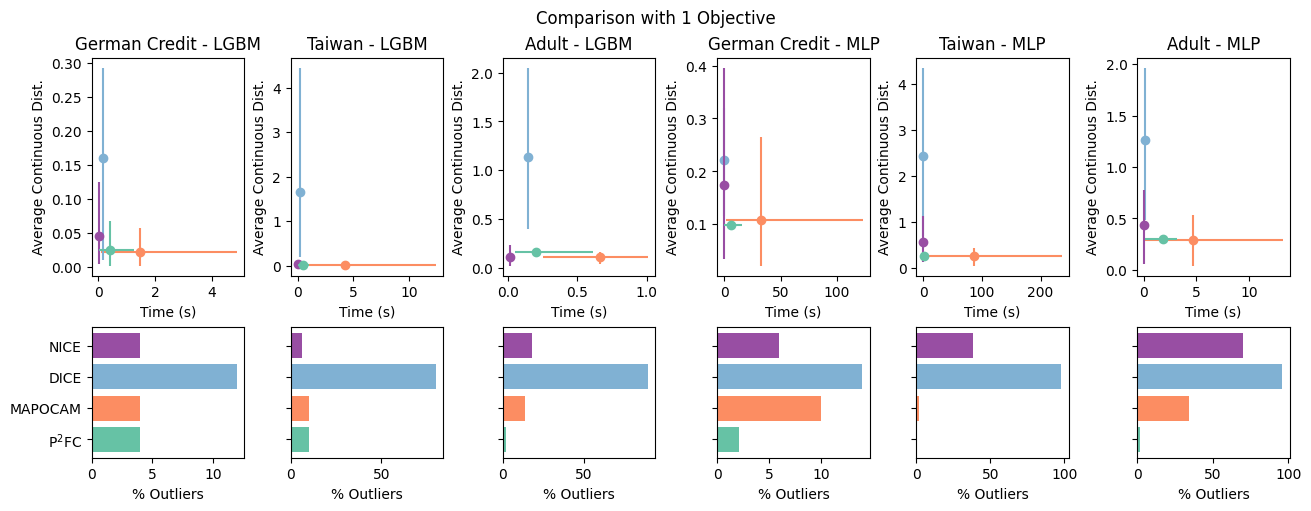

In [406]:
fig = plt.figure(figsize = (13, 5), layout = "constrained")
axs = fig.subplots(nrows = 2, ncols = 6, height_ratios=[1, 0.6])

for i, dataset_name in enumerate(["german", "taiwan", "adult"]):
    for j, model in enumerate(["lgbm", "mlp"]):
        results = []
        if model == "lgbm":
            method_list = ["mapofcem_tree_abs_diff", "mapocam_tree_abs_diff", "dice", "nice"]
        else:
            method_list = ["mapofcem_deep_abs_diff", "mapocam_abs_diff", "dice", "nice"]

        for method in method_list:
            try:
                results_cur = pd.read_csv(f"../results/{model}/{dataset_name}/{method}.csv")
                results_cur = summarize_results(results_cur, dataset_name)

                if "mapofcem" in method:
                    method = "mapofcem_abs_diff"
                if "mapocam" in method:
                    method = "mapocam_abs_diff"
                    
                results_cur["method"] = method
                results.append(results_cur)
            except:
                pass
        
        results = pd.concat(results)
        results["costs"] = results["abs_diff_costs"]
        axs_ = [axs[0][j * 3 + i], axs[1][j * 3 + i]]
        plot_test(results, axs_)

        axs[0][j * 3 + i].set_title(f"{dataset_naming(dataset_name)} - {model.upper()}")

for i in range(1, 6):
    axs[1][i].set_yticklabels([])

plt.suptitle("Comparison with 1 Objective")
plt.savefig("../figures/percentile_results.pdf", dpi = 300)

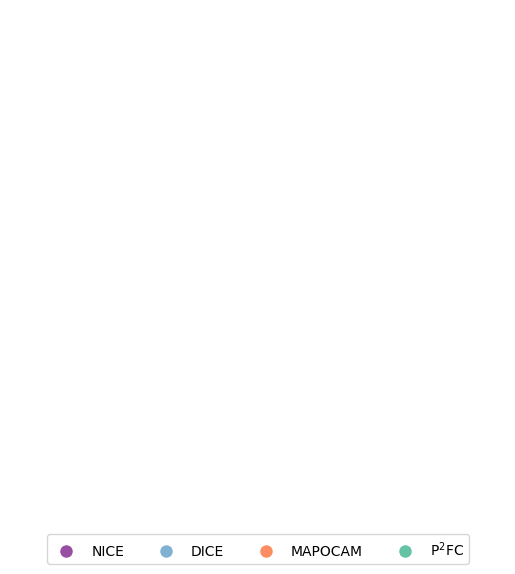

In [408]:
# plot the legend separately

fig = plt.figure()
handles = [
    Line2D(
        [0],
        [0],
        marker = "o",
        color = "w",
        markerfacecolor =  methods_coloring(name),
        markersize = 10,
        label = methods_naming(name),
    ) for name in results.method.unique()
]
handles = handles[::-1]
plt.axis("off")
plt.legend(handles=handles, ncol = len(handles), loc='upper center', bbox_to_anchor=(0.5, -0.4),)
plt.savefig("../figures/percentile_legend.pdf", dpi = 300)

## Comaparison with multiple objectives

In [232]:
def get_idx_non_dom(S):
    idx = []
    for i, s1 in enumerate(S):
        non_dominated = True
        for j, s2 in enumerate(S):
            if i == j:
                continue
            if all(s2 <= s1):
                if (s1 - s2).sum() < 1e-8:
                    # are the same solution
                    continue
                non_dominated = False
                break
        if non_dominated:
            idx.append(i)
    return idx

In [245]:
comparison = {}

for dataset in ["german", "taiwan", "adult"]:
    costs = {}
    method_list = ["mapofcem_deep_multi", "mapocam_multi",  "dice_multi"]
    for method in method_list:
        results = pd.read_csv(f"../results/mlp/{dataset}/{method}.csv")
        results = summarize_results_multi(results, dataset)
        costs[method] = results[["abs_diff_costs", "max_dist_costs", "n_changes"]].values
        costs[method] = costs[method].tolist()

        for i in range(len(costs[method])):
            costs[method][i] = list(zip(*costs[method][i]))

    
    best_solution_counter = dict([(method, 0) for method in method_list])
    for i in range(50):
        solutions = []
        method_name = []
        for method in method_list:
            solutions += costs[method][i]
            method_name += [method] * len(costs[method][i])

        solutions = [np.array(s) for s in solutions]
        idx = get_idx_non_dom(solutions)
        best_methods = list(set([method_name[i] for i in idx]))

        for method in best_methods:
            best_solution_counter[method] += 1

    print(dataset)
    print(best_solution_counter)


german
{'mapofcem_deep_multi': 45, 'mapocam_multi': 49, 'dice_multi': 7}
taiwan
{'mapofcem_deep_multi': 35, 'mapocam_multi': 50, 'dice_multi': 33}
adult
{'mapofcem_deep_multi': 37, 'mapocam_multi': 50, 'dice_multi': 14}


In [246]:
dataset = "german"
method_list = ["mapocam_tree_multi", "mapofcem_tree_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/lgbm/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])

,method,percentile_costs,lp_costs,max_dist_costs,abs_diff_costs,n_changes,outlier,diversity,n_solutions,time
0,dice_multi,0.42 (+-0.134) | 0.681,3.394 (+-0.796) | 4.724,3.01 (+-0.644) | 4.034,0.161 (+-0.043) | 0.237,1.705 (+-0.241) | 2.0,0.095 (+-0.225) | 0.5,0.918 (+-0.077) | 1.0,4.0 (+-0.0) | 4.0,0.181 (+-0.005) | 0.187
1,mapocam_tree_multi,0.191 (+-0.175) | 0.542,0.593 (+-0.489) | 1.476,0.575 (+-0.462) | 1.353,0.024 (+-0.021) | 0.064,1.14 (+-0.268) | 1.5,0.04 (+-0.198) | 0.0,0.24 (+-0.431) | 1.0,1.26 (+-0.487) | 2.0,2.226 (+-3.092) | 7.078
2,mapofcem_tree_multi,0.192 (+-0.17) | 0.5,0.643 (+-0.561) | 1.564,0.618 (+-0.518) | 1.446,0.026 (+-0.025) | 0.072,1.17 (+-0.313) | 2.0,0.035 (+-0.175) | 0.0,0.26 (+-0.443) | 1.0,1.36 (+-0.722) | 2.55,0.932 (+-1.735) | 2.787


In [247]:
dataset = "taiwan"
method_list = ["mapocam_tree_multi", "mapofcem_tree_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/lgbm/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])

,method,percentile_costs,lp_costs,max_dist_costs,abs_diff_costs,n_changes,outlier,diversity,n_solutions,time
0,dice_multi,0.65 (+-0.177) | 0.902,17.428 (+-7.047) | 28.703,17.081 (+-6.901) | 27.409,1.72 (+-0.71) | 3.119,1.65 (+-0.242) | 2.0,0.87 (+-0.21) | 1.0,0.997 (+-0.012) | 1.0,4.0 (+-0.0) | 4.0,0.991 (+-4.016) | 0.321
1,mapocam_tree_multi,0.216 (+-0.159) | 0.496,0.392 (+-0.431) | 1.065,0.379 (+-0.42) | 1.053,0.039 (+-0.042) | 0.103,1.423 (+-0.41) | 2.0,0.127 (+-0.298) | 1.0,0.58 (+-0.498) | 1.0,1.82 (+-0.8) | 3.0,7.959 (+-12.262) | 31.632
2,mapofcem_tree_multi,0.217 (+-0.16) | 0.458,0.574 (+-0.776) | 1.966,0.568 (+-0.773) | 1.958,0.054 (+-0.072) | 0.183,1.367 (+-0.396) | 2.0,0.06 (+-0.218) | 0.5,0.44 (+-0.501) | 1.0,1.56 (+-0.705) | 3.0,0.484 (+-0.563) | 1.858


In [248]:
dataset = "adult"
method_list = ["mapocam_tree_multi", "mapofcem_tree_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/lgbm/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])

,method,percentile_costs,lp_costs,max_dist_costs,abs_diff_costs,n_changes,outlier,diversity,n_solutions,time
0,dice_multi,0.785 (+-0.224) | 0.891,7.695 (+-1.963) | 10.616,7.375 (+-1.942) | 10.135,1.091 (+-0.284) | 1.519,1.48 (+-0.236) | 1.75,0.88 (+-0.162) | 1.0,1.0 (+-0.0) | 1.0,4.0 (+-0.0) | 4.0,0.17 (+-0.006) | 0.181
1,mapocam_tree_multi,0.706 (+-0.277) | 0.864,0.867 (+-0.332) | 1.256,0.84 (+-0.283) | 1.235,0.116 (+-0.056) | 0.181,1.14 (+-0.268) | 1.5,0.14 (+-0.336) | 1.0,0.22 (+-0.418) | 1.0,1.24 (+-0.476) | 2.0,0.912 (+-0.449) | 1.238
2,mapofcem_tree_multi,0.71 (+-0.265) | 0.864,1.08 (+-0.881) | 3.186,1.016 (+-0.732) | 2.34,0.159 (+-0.173) | 0.577,1.284 (+-0.533) | 2.425,0.011 (+-0.075) | 0.0,0.159 (+-0.37) | 1.0,1.02 (+-0.515) | 2.0,0.942 (+-1.073) | 3.228


In [249]:
dataset = "german"
method_list = ["mapocam_multi", "mapofcem_deep_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/mlp/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])

,method,percentile_costs,lp_costs,max_dist_costs,abs_diff_costs,n_changes,outlier,diversity,n_solutions,time
0,dice_multi,0.474 (+-0.166) | 0.755,4.488 (+-0.952) | 6.194,3.789 (+-0.62) | 4.818,0.231 (+-0.085) | 0.398,2.05 (+-0.662) | 3.162,0.2 (+-0.357) | 1.0,0.813 (+-0.127) | 0.99,4.0 (+-0.0) | 4.0,0.229 (+-0.057) | 0.312
1,mapocam_multi,0.268 (+-0.126) | 0.457,3.42 (+-1.009) | 5.333,2.982 (+-0.571) | 4.009,0.164 (+-0.076) | 0.311,1.898 (+-0.545) | 2.734,0.144 (+-0.3) | 1.0,0.641 (+-0.252) | 0.993,6.98 (+-2.487) | 10.0,49.623 (+-42.407) | 136.05
2,mapofcem_deep_multi,0.272 (+-0.116) | 0.496,3.273 (+-0.856) | 4.93,2.862 (+-0.521) | 3.745,0.156 (+-0.064) | 0.302,1.898 (+-0.532) | 2.738,0.05 (+-0.165) | 0.294,0.708 (+-0.221) | 0.999,6.52 (+-2.62) | 9.55,9.316 (+-6.073) | 18.532


In [250]:
dataset = "taiwan"
method_list = ["mapocam_multi", "mapofcem_deep_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/mlp/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])

,method,percentile_costs,lp_costs,max_dist_costs,abs_diff_costs,n_changes,outlier,diversity,n_solutions,time
0,dice_multi,0.607 (+-0.218) | 0.922,25.306 (+-8.22) | 38.561,25.067 (+-8.183) | 38.528,2.433 (+-0.778) | 3.624,1.585 (+-0.218) | 1.887,0.935 (+-0.158) | 1.0,0.978 (+-0.119) | 1.0,4.0 (+-0.0) | 4.0,0.277 (+-0.019) | 0.31
1,mapocam_multi,0.314 (+-0.094) | 0.481,2.313 (+-0.858) | 3.385,1.903 (+-0.641) | 2.776,0.3 (+-0.131) | 0.472,2.193 (+-0.454) | 2.667,0.115 (+-0.248) | 0.667,0.792 (+-0.328) | 1.0,2.74 (+-1.306) | 4.0,118.51 (+-96.821) | 308.407
2,mapofcem_deep_multi,0.314 (+-0.108) | 0.518,1.911 (+-0.769) | 3.212,1.691 (+-0.689) | 2.945,0.226 (+-0.097) | 0.355,1.942 (+-0.438) | 2.5,0.007 (+-0.042) | 0.0,0.571 (+-0.464) | 1.0,1.46 (+-1.265) | 4.0,0.813 (+-0.943) | 2.195


In [251]:
dataset = "adult"
method_list = ["mapocam_multi", "mapofcem_deep_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/mlp/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])

,method,percentile_costs,lp_costs,max_dist_costs,abs_diff_costs,n_changes,outlier,diversity,n_solutions,time
0,dice_multi,0.801 (+-0.106) | 0.891,7.289 (+-2.028) | 10.661,6.986 (+-2.009) | 10.368,1.033 (+-0.291) | 1.537,1.55 (+-0.262) | 2.0,0.865 (+-0.19) | 1.0,0.998 (+-0.006) | 1.0,4.0 (+-0.0) | 4.0,0.187 (+-0.009) | 0.201
1,mapocam_multi,0.696 (+-0.107) | 0.779,2.69 (+-1.217) | 4.959,2.087 (+-0.836) | 3.604,0.502 (+-0.259) | 0.995,2.304 (+-0.434) | 2.667,0.579 (+-0.319) | 1.0,0.991 (+-0.027) | 1.0,7.94 (+-4.098) | 14.55,6.243 (+-4.275) | 11.911
2,mapofcem_deep_multi,0.578 (+-0.14) | 0.776,2.221 (+-0.858) | 3.365,1.885 (+-0.687) | 2.724,0.372 (+-0.165) | 0.616,1.954 (+-0.44) | 2.527,0.11 (+-0.224) | 0.5,0.827 (+-0.37) | 1.0,3.64 (+-3.102) | 10.55,2.344 (+-1.389) | 4.638


## Example comparison of Counterfactual Explanations

In [266]:
i = 2
dataset_name = "adult"
SEED = 0
dataset, X_train, _, model, outlier_detection, individuals = get_data_model(dataset_name, "MLPClassifier")
individuals = individuals.sample(n = 50, random_state=SEED)

# get the solution of individual i for each method
method_list = ["mapofcem_deep_multi", "mapocam_multi", "dice_multi"]
df_temp = []
for method in method_list:
    results = pd.read_csv(f"../results/mlp/{dataset_name}/{method}.csv")

    solutions = literal_eval(results["solutions"].iloc[i])
    for s in solutions:
        s_df = pd.DataFrame([s], columns = X_train.columns.tolist())
        extra_columns = [
            method,
            outlier_detection.predict(np.array([s]))[0],
            model.predict_proba(s_df)[0, 1],
        ]
        df_temp.append(s + extra_columns)

extra_columns = [
    "individual",
    1,
    model.predict_proba(individuals.iloc[i:i+1])[0, 1],
]
df_temp.append(
    individuals.iloc[i].tolist() + extra_columns
)
df_temp = df_temp[::-1]
df_temp = pd.DataFrame(df_temp, columns = X_train.columns.tolist() + ["method", "outlier", "pred"])


In [267]:
not_unique_value_cols = []
for col in df_temp.columns:
    if len(df_temp[col].unique()) > 1:
        not_unique_value_cols.append(col)
df_temp = df_temp[not_unique_value_cols]

In [270]:
df_temp

,capital_gain,capital_loss,hours_per_week,has_degree,is_married,gov_job,method,outlier,pred
0,0,0,30,0,0,0,individual,1,0.323568
1,36470,0,30,0,1,0,dice_multi,-1,0.645454
2,39877,0,30,0,0,0,dice_multi,-1,0.534616
3,0,0,97,0,1,0,dice_multi,-1,0.613924
4,21794,0,97,0,0,0,dice_multi,-1,0.627242
5,0,1980,30,1,0,1,mapocam_multi,-1,0.500143
6,4512,891,30,0,1,0,mapocam_multi,-1,0.503804
7,5264,792,30,0,1,0,mapocam_multi,-1,0.504073
8,10528,0,30,0,1,0,mapocam_multi,-1,0.500852
9,0,0,30,1,1,0,mapocam_multi,1,0.544262


In [276]:
from pygmo import hypervolume

In [368]:
def remove_dominated_solutions(A):
    """From a list of costs, keep only the non-dominated solutions."""
    non_dominated = []
    for i, s1 in enumerate(A):
        dominated = False
        for j, s2 in enumerate(A):
            if i == j:
                continue
            if all(s2 <= s1):
                if (s1 - s2).sum() < 1e-8:
                    # are the same solution
                    continue

                dominated = True
                break
        if not dominated:
            non_dominated.append(s1)

    return non_dominated

In [392]:
def get_experiments_multi_costs(
    dataset_name,
    method_name,
    model_name,
    keep_dominated = False
):  
    """Get the costs of the experiments for a multi-objective method.
    It will return an list of numpy arrays, where each array contains the costs of the solutions for an individual.
    """
    results = pd.read_csv(f"../results/{model_name}/{dataset_name}/{method_name}.csv")
    results = summarize_results_multi(results, dataset_name)
    costs = results[["abs_diff_costs", "max_dist_costs", "n_changes"]].values
    costs = costs.tolist()
    costs = [np.array(list(zip(*c))) for c in costs]
    if not keep_dominated:
        costs = [remove_dominated_solutions(c) for c in costs]
    return costs

In [393]:
results = []
for dataset in ["german", "taiwan", "adult"]:
    costs = {}
    method_list = ["mapofcem_tree_multi", "mapocam_tree_multi",  "dice_multi"]
    for method in method_list:
        costs[method] = get_experiments_multi_costs(dataset, method, "lgbm", keep_dominated = False)


    # get maximum cost for each objective
    max_costs = np.ones(len(costs[method][0][0])) * -np.inf

    for method in method_list:
        for i in range(50): # for each individual
            if len(costs[method][i]) == 0:
                continue
            max_costs = np.maximum(max_costs, np.max(costs[method][i], axis = 0))

    
    # calculate hypervolume of each method
    for method in method_list:
        for i in range(50):
            if len(costs[method][i]) == 0:
                hv = 0
            else:
                costs_ = costs[method][i]
                costs_ /= max_costs
                hv = hypervolume(costs_).compute(np.ones(len(max_costs)))

            results.append([dataset, method, i, hv])
results = pd.DataFrame(results, columns = ["dataset", "method", "individual", "hv"])

def make_table(df):
    hv_mean = df["hv"].mean().round(2)
    hv_std = df["hv"].std().round(2)
    return f"{hv_mean} ($\pm$ {hv_std})"
results.groupby(["dataset", "method"]).apply(make_table)

dataset  method             
adult    dice_multi             0.35 ($\pm$ 0.16)
         mapocam_tree_multi     0.58 ($\pm$ 0.06)
         mapofcem_tree_multi     0.48 ($\pm$ 0.2)
german   dice_multi             0.31 ($\pm$ 0.21)
         mapocam_tree_multi     0.53 ($\pm$ 0.11)
         mapofcem_tree_multi    0.52 ($\pm$ 0.12)
taiwan   dice_multi             0.41 ($\pm$ 0.15)
         mapocam_tree_multi     0.65 ($\pm$ 0.02)
         mapofcem_tree_multi    0.64 ($\pm$ 0.07)
dtype: object

In [395]:
results = []
for dataset in ["german", "taiwan", "adult"]:
    costs = {}
    method_list = ["mapofcem_deep_multi", "mapocam_multi",  "dice_multi"]
    for method in method_list:
        costs[method] = get_experiments_multi_costs(dataset, method, "mlp", keep_dominated = False)


    # get maximum cost for each objective
    max_costs = np.ones(len(costs[method][0][0])) * -np.inf

    for method in method_list:
        for i in range(50): # for each individual
            if len(costs[method][i]) == 0:
                continue
            max_costs = np.maximum(max_costs, np.max(costs[method][i], axis = 0))

    
    # calculate hypervolume of each method
    for method in method_list:
        for i in range(50):
            if len(costs[method][i]) == 0:
                hv = 0
            else:
                costs_ = costs[method][i]
                costs_ /= max_costs
                hv = hypervolume(costs_).compute(np.ones(len(max_costs)))

            results.append([dataset, method, i, hv])
results = pd.DataFrame(results, columns = ["dataset", "method", "individual", "hv"])

def make_table(df):
    hv_mean = df["hv"].mean().round(2)
    hv_std = df["hv"].std().round(2)
    return f"{hv_mean} ($\pm$ {hv_std})"
results.groupby(["dataset", "method"]).apply(make_table)

dataset  method             
adult    dice_multi             0.27 ($\pm$ 0.14)
         mapocam_multi          0.42 ($\pm$ 0.17)
         mapofcem_deep_multi     0.4 ($\pm$ 0.18)
german   dice_multi             0.24 ($\pm$ 0.16)
         mapocam_multi           0.45 ($\pm$ 0.2)
         mapofcem_deep_multi    0.44 ($\pm$ 0.21)
taiwan   dice_multi             0.27 ($\pm$ 0.16)
         mapocam_multi          0.41 ($\pm$ 0.16)
         mapofcem_deep_multi    0.39 ($\pm$ 0.16)
dtype: object